# Transcription audio

In [1]:
import os
import soundfile as sf

audio_folder = "audio_wav"

for filename in os.listdir(audio_folder):
    if filename.lower().endswith(('.wav', '.m4a', '.mp3', '.flac', '.ogg', '.mp4')):
        filepath = os.path.join(audio_folder, filename)
        try:
            info = sf.info(filepath)
            status = []
            if info.samplerate != 16000:
                status.append("⚠️ Pas 16kHz")
            if info.channels != 1:
                status.append("⚠️ Pas mono")
            print(f"{filename}: {info.samplerate} Hz, {info.channels} canaux, {info.format}, {info.duration:.2f} sec {' '.join(status)}")
        except Exception as e:
            print(f"{filename}: Erreur - {e} (à convertir en WAV mono 16kHz)")

enreJerome1.wav: 16000 Hz, 1 canaux, WAV, 61.72 sec 
enreJerome2.wav: 16000 Hz, 1 canaux, WAV, 39.51 sec 
enreJulien1.wav: 16000 Hz, 1 canaux, WAV, 104.13 sec 
enreJulien2.wav: 16000 Hz, 1 canaux, WAV, 75.23 sec 
enreJulien3.wav: 16000 Hz, 1 canaux, WAV, 111.75 sec 
enreJulien4.wav: 16000 Hz, 1 canaux, WAV, 103.37 sec 
enreVincent1.wav: 16000 Hz, 1 canaux, WAV, 106.69 sec 
enreVincent2.wav: 16000 Hz, 1 canaux, WAV, 96.87 sec 


In [ ]:
import os
import time
import psutil
import csv
import json
from vosk import Model, KaldiRecognizer
import soundfile as sf
from jiwer import wer
import time
import librosa

# Configs
VOSK_MODEL_PATH_SMALL = "vosk-model-small-fr-0.22"
VOSK_MODEL_PATH = "vosk-model-fr-0.22"
AUDIO_DIR = "audio_wav"
CSV_OUTPUT = "transcription_performance.csv"

# Charger modèles
vosk_model_small = Model(VOSK_MODEL_PATH_SMALL)
vosk_model = Model(VOSK_MODEL_PATH)


# Références: dictionnaire { nom_fichier: texte_reference }
references = {
    "enreJerome1.wav": "il sagit de monsieur jeanique mohamed pour la réalisation d'une thermoablation par microondes d'une métastase épatique dorigine renale c'est une décision de rcp le patient a été vu en consultation la checkliste du bloc a été faite on va faire un guidage sous écographie on a prit l'écographe principal l'ablation va être faite avec le générateur en angiodynamique on a le générateur soléro oui une aiguille de 14 cm aiguille unique on a une poche de froid comme cest nécessaire on va faire un bord sous écho par voie sous xifoïdienne une seule aiguille bien centrée une ablation on part sur une ablation de 6 minutes à la puissance de 100 watts une fois que ce sera terminé le patient sera réveillé et normalement la sortie est prévue demain merci",    
    "enreJerome2.wav": "il sagit de madame déjésus on va faire une embolisation veineuse pelvienne on lui a déjà fait la phébographie diagnostique la semaine dernière qui a retrouvée une seule grosse veine gonadique gauche donc on va piquer en 5 french on va recathétériser avec le même matériel cobra 5 lembolisation se fera avec de lonix on a mis le flacon donyx 346 à secouer on utilisera un micro 4 truselecto une fois que ca sera fini il remontera en chirambu et on lui donnera un rendez vous de consultation à trois mois allez cest parti merci à tous",
    "enreJulien1.wav": "bonjour aujourdhui on va faire une radio fréquence dun nodule pulmonaire du lobe moyen il sagit dune métastase probablement dun cancer prostatique donc pour ce faire on va installer le patient en decobutus dorsale le geste sera fait sous anesthésie générale et on va procéder avec donc vu la localisation de la lesion on aura probablement pas besoin de faire un pneumothorax donc on pourra peutêtre prendre des balettes de 3 cm ou de 35 cm et donc on va essayer daller par un abord direct estce quon va prendre de la jet lanesthésiste demande si on prend de la jet pour ce patient je pense quon na pas besoin de prendre de la jet tu le mets comment  on demande on le met sur le dos ou sur le côté  voilà et après je te pose une question con mais est ce que je te prend le matériel de biopsie on a déjà fait une biopsie on a déjà fait  ah pardon alors juste lablation  de la radio fréquence je te ramène le materiel aller go",
    "enreJulien2.wav": "ok donc on a monsieur sanjogé george cest une embolisation de la prostate pour un patient qui a un adénome donc on part sur un geste assez classique on fera scopi scan comme on fait dhabitude donc faut bien préparer le scan patient allongé sous sédation et même je voudrais quil soit sousagé parce quaujourdhui attention soyez vigilant on va utiliser un nouveau matériel cest le micro catéter sniper cest du 27 daccord donc il est assez gros je ne sais pas si on va arriver à lamener jusquà la prostate mais je crois que le bout il est plus petit non je crois que le bout il est en 22 cest un catéter avalon qui va nous permettre dinjecter de lonyx donc comme vous le savez lonyx ça fait mal donc il faudra bien quil dorme au moment de linjection et ça ne coûtera rien de rajouter un peu de xylo quand on va injecter donc il faudra bien préparer donc vu quon veut utiliser de lonyx je vous propose de dès à présent commencer à lagiter et sinon au niveau technique donc on va rester en 4 french on va faire comme dhabitude un abord fémorale droit cest un geste que je pense quil ne va pas être trop long à mon avis il faut que dans deux heures ça soit terminé en tout cas on la prévue sur deux heures maximum et le patient derrière il est en hdj il retournera chez lui donc pensez bien faire le courrier dhdj allez go",
    "enreJulien3.wav": "bonjour tout le monde aujourdhui on va traiter madame sally fatima qui se plaint de rectoragie abondante depuis quelques mois avec anémie nécessitant des transfusions donc aujourdhui on va traiter on va emboliser les hémorroïde interne donc ce sera un abord fémoral droit en quatre franch on va prendre une sonde sim 1 pour cathétériser lartère mésentérique inférieure et après un micro cathétaire 20 ou 19 quest ce quon a en micro cathétaire  on prendra un boston 19 et on va prendre un micro guide fathome donc là on va cathétériser quest ce quil nous faut dautre  on prépare linjecteur pour faire une artérographie au niveau de lartère mésentérique inférieure et on va emboliser avec des coils et des petits coils nester ou tournado 2 mm et 3 mm donc on prépare tout ça une simple sédation suffit on na pas besoin de lanesthésie générale la patiente elle est bien consciente on discutera au fur et à mesure sil y a un souci donc après si on va déceler des branches de lartère rectal moyenne en opacifiant au niveau de lartère rectal inférieur au niveau des rectales supérieures si on décelle des rectales moyennes on va les emboliser en passant par lartère illiaque interne voilà donc faites bien la vérification que tout est bien on a besoin de la scopie de la graphie on na pas besoin de scanner et voilà on vérifie quil ny a pas dallergie au produit de contraste pas dallergie à la bétadine",
    "enreJulien4.wav": "ok donc on va soccuper de monsieur poveda donc cest un patient qui vient pour une tumeur du foie cest un chc on a déjà fait la biopsie ce chc il nest pas visible en imagerie donc il faudra quon lui fasse un marquage lipyodolé donc les manipes il faut que vous prépailliez la table pour faire un abort artériel il ny a pas de liguament arqué donc on va y aller avec une sonde cobra on fera un abort fémoral droit chez lui et on utilisera du lipyodole on prendra environ 2 cc quon mélangera avec 5 cc deau et il faudra aller dans lartérien hépatique droite pour opacifier son nodule pour être sûr quon la bien opacifié on fera un scan donc il faut préparer le scan donc il nous faudra langio et le scan un abort artériel au scan dès quon voit le nodule on lui fera un traitement percutané on va choisir des microondes cest une lésion qui est dans le segment 7 donc il faut amener laiguille de microondes elle est collée au diaphragme donc il va falloir quon décolle donc on prendra des aiguilles schibas et on prendra soit du liquide soit du co2 donc il va nous falloir du liquide du co2 quand vous allez prendre le liquide cest important de mettre un peu de contraste pas trop pour pas quil y ait dartefac donc vous mettez 1 cc à peu près pour 20 cc deau et vous ferez vu la localisation et la taille du nodule je vous propose de faire 100 watts 10 minutes donc le patient il sera sousagé bien sûr il sera en décutbitus dorsale et il faudra bien lui lever la main droite au dessus de la tête donc quand vous avez levé la main droite vous faites bien attention à son plexus brachial pour pas quitter de complication au réveil estce que vous avez bien compris  ah il y a lanesthésie ce qui me demande si on met de la jet effectivement vu que la lésion est dans le domes il faudra quon ait la jet donc vous mettez la jet au moment de lablation pas avant allez go",
    "enreVincent1.wav": "bonjour nous faisons le briefing du patient rémi dubois donc lidentité a bien été vérifiée donc il sagit dune embolisation dhémoroïdes alors nous allons installer monsieur rémi dubois en position normale dans la salle avec un échographe en place et du méopa pour lanesthésie pour réaliser lintervention jai besoin dun introducteur 4 french dune sonde sidewinder 4f dun micro cathétaire de type direction bern jutiliserai des microcoils de type micro nester 27 mm chez ce patient nous avons identifié des troubles de la coagulation il est donc nécessaire de réaliser une fermeture du point de ponction à laide dun système de fermeture type exhaustile 5f il y a par ailleurs aussi une insuffisance rénale limite donc il sera très important de limiter au maximum linjection de produit de contraste et de prévoir une hydratation après il a été également identifié une allergie au produit de contraste normalement le patient a dû être préparé pendant trois jours est ce que cette préparation médicamentale ça a bien été faite ok il ny a pas dautre facteur de risque évoqué donc on peut installer le patient",
    "enreVincent2.wav": "bonjour on attaque le briefing pour monsieur vincent vidal donc lidentité a bien été vérifiée ok donc le patient va être installé en position standard sur la table avec comme matériel disponible un écographe pour faire la ponction du méopa pour lanesthésie nous allons pratiquer une embolisation de prostate il va donc falloir faire un abort fémoral 6 french au niveau du pli inguinal droit ensuite mettre en place un cathétère guide rdc6f on fera des injections à la seringue électrique avec du produit contraste dilué à 50 jaurais besoin comme micro cathétère de type progreat avec des guides de terumo 0 0 16 inch ensuite je vais prendre comme agent dembolisation des microsphères type embosphère 500700 et des microcoil de type nester 27 mm il ny a pas de problématique identifiée très clairement chez ce patient notamment pas de problème de coagulation ou de fonction renale voilà est ce quil y a des questions particulières"
}

def transcrire_vosk_small(audio_path):
    rec = KaldiRecognizer(vosk_model_small, 16000)
    with sf.SoundFile(audio_path) as f:
        while True:
            data = f.read(4000, dtype='int16')
            if len(data) == 0:
                break
            rec.AcceptWaveform(data.tobytes())
    result_json = rec.FinalResult()
    result = json.loads(result_json)
    return result.get("text", "")

def transcrire_vosk(audio_path):
    rec = KaldiRecognizer(vosk_model, 16000)
    with sf.SoundFile(audio_path) as f:
        while True:
            data = f.read(4000, dtype='int16')
            if len(data) == 0:
                break
            rec.AcceptWaveform(data.tobytes())
    result_json = rec.FinalResult()
    result = json.loads(result_json)
    return result.get("text", "")


def mesure_performance(func, audio_path, *args):
    # Obtenir la durée du fichier audio
    try:
        audio_duration = librosa.get_duration(path=audio_path)
    except Exception as e:
        print(f"Erreur lors du calcul de la durée : {e}")
        audio_duration = 1  # éviter une division par zéro
    
    # Mesurer performances
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024  # Mo
    time_start = time.time()
    output = func(audio_path, *args)
    time_end = time.time()
    mem_after = process.memory_info().rss / 1024 / 1024  # Mo
    
    # Calculs
    elapsed = time_end - time_start
    elapsed_per_sec = elapsed / audio_duration  # normalisation par durée
    mem_used = max(mem_after - mem_before, 0)

    return output, elapsed, elapsed_per_sec, mem_used

def count_tokens(text):
    return len(text.split())

def separator_line(char="=", length=60):
    print(char * length)

def main():
    files = [f for f in os.listdir(AUDIO_DIR) if f.lower().endswith(".wav")]
    with open(CSV_OUTPUT, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = [
            "fichier",
            "modele",
            "latency_sec",
            "memory_mb",
            "duration_sec",
            "latency_per_sec",
            "latency_per_token",
            "latency_normalized",
            "memory_per_sec",
            "memory_per_token",
            "tokens",
            "tokens_per_sec",
            "wer",
            "transcript"
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for f in files:
            separator_line()
            print(f"🌟 Début traitement du fichier audio : {f} 🌟")
            audio_path = os.path.join(AUDIO_DIR, f)
            audio_info = sf.info(audio_path)
            duration = audio_info.duration

            ref_text = references.get(f, "")

            # Vosk Small
            print(f"▶️  Transcription avec Vosk SMALL pour {f}...")
            vosk_small_text, vosk_small_time, vosk_small_time_per_sec, vosk_small_mem = mesure_performance(transcrire_vosk_small, audio_path)
            vosk_small_tokens = count_tokens(vosk_small_text)
            vosk_small_wer = wer(ref_text, vosk_small_text) if ref_text else -1
            vosk_small_row = {
                "fichier": f,
                "modele": "Vosk SMALL",
                "latency_sec": vosk_small_time,
                "memory_mb": vosk_small_mem,
                "duration_sec": duration,
                "latency_per_sec": vosk_small_time / duration if duration > 0 else -1,
                "latency_per_token": vosk_small_time / vosk_small_tokens if vosk_small_tokens > 0 else -1,
                "latency_normalized": vosk_small_time_per_sec,
                "memory_per_sec": vosk_small_mem / duration if duration > 0 else -1,
                "memory_per_token": vosk_small_mem / vosk_small_tokens if vosk_small_tokens > 0 else -1,
                "tokens": vosk_small_tokens,
                "tokens_per_sec": vosk_small_tokens / vosk_small_time if vosk_small_time > 0 else -1,
                "wer": vosk_small_wer,
                "transcript": vosk_small_text
            }
            writer.writerow(vosk_small_row)
            print(f"✅ [Vosk SMALL] Transcription terminée pour {f} - Durée : {vosk_small_time:.2f}s, WER : {vosk_small_wer:.3f}")

            # Vosk
            print(f"▶️  Transcription avec Vosk pour {f}...")
            vosk_text, vosk_time, vosk_time_per_sec, vosk_mem = mesure_performance(transcrire_vosk, audio_path)
            vosk_tokens = count_tokens(vosk_text)
            vosk_wer = wer(ref_text, vosk_text) if ref_text else -1
            vosk_row = {
                "fichier": f,
                "modele": "Vosk",
                "latency_sec": vosk_time,
                "memory_mb": vosk_mem,
                "duration_sec": duration,
                "latency_per_sec": vosk_time / duration if duration > 0 else -1,
                "latency_per_token": vosk_time / vosk_tokens if vosk_tokens > 0 else -1,
                "latency_normalized": vosk_time_per_sec,
                "memory_per_sec": vosk_mem / duration if duration > 0 else -1,
                "memory_per_token": vosk_mem / vosk_tokens if vosk_tokens > 0 else -1,
                "tokens": vosk_tokens,
                "tokens_per_sec": vosk_tokens / vosk_time if vosk_time > 0 else -1,
                "wer": vosk_wer,
                "transcript": vosk_text
            }
            writer.writerow(vosk_row)
            print(f"✅ [Vosk] Transcription terminée pour {f} - Durée : {vosk_time:.2f}s, WER : {vosk_wer:.3f}")


            separator_line()

if __name__ == "__main__":
    main()

🌟 Début traitement du fichier audio : enreJerome1.wav 🌟
▶️  Transcription avec Vosk SMALL pour enreJerome1.wav...
✅ [Vosk SMALL] Transcription terminée pour enreJerome1.wav - Durée : 79.85s, WER : 0.554
▶️  Transcription avec Vosk pour enreJerome1.wav...
✅ [Vosk] Transcription terminée pour enreJerome1.wav - Durée : 78.49s, WER : 0.477
▶️  Transcription avec Vosk Medical pour enreJerome1.wav...


: 

In [17]:
# Importer le CSV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importer le CSV
data=pd.read_csv("transcription_performance.csv")

# afficher information de base sur les données
print(data.head())
print(data.info())
print(data.describe())

           fichier      modele  latency_sec  memory_mb  duration_sec  \
0  enreJerome1.wav  Vosk SMALL    22.821787   0.187500     61.717312   
1  enreJerome1.wav        Vosk    25.754428   1.175781     61.717312   
2  enreJerome2.wav  Vosk SMALL    20.372451   0.000000     39.509313   
3  enreJerome2.wav        Vosk    16.113164   0.472656     39.509313   
4  enreJulien1.wav  Vosk SMALL    34.703286   0.000000    104.133500   

   latency_per_sec  latency_per_token  latency_normalized  memory_per_sec  \
0         0.369779           0.181125            0.369779        0.003038   
1         0.417297           0.198111            0.417297        0.019051   
2         0.515637           0.212213            0.515637        0.000000   
3         0.407832           0.161132            0.407832        0.011963   
4         0.333258           0.222457            0.333258        0.000000   

   memory_per_token  tokens  tokens_per_sec       wer  \
0          0.001488     126        5.521040  0.

Voici ce que représentent les principales features de votre dataset :

- fichier : Le nom du fichier audio enregistré pour le modèle.
- modele : Le nom du modèle de reconnaissance vocale utilisé (ex: Vosk, Whispertiny).
- latency_sec : La latence totale d'exécution du modèle en secondes.
- memory_mb : La mémoire utilisée par le modèle en mégaoctets.
- duration_sec : La durée totale de l'audio à transcrire en secondes.
- latency_per_sec : La latence par seconde d'audio traitée.
- latency_per_token : La latence moyenne par token traité.
- memory_per_sec : La mémoire utilisée par seconde d'audio.
- memory_per_token : La mémoire utilisée par token traité.
- tokens : Le nombre total de tokens générés dans la transcription.
- tokens_per_sec : Le nombre de tokens générés par seconde.
- wer : Le taux d'erreur de mots (Word Error Rate) indiquant la qualité de la transcription (plus bas est meilleur).
- transcript : Le texte de la transcription produite par le modèle.

Ces métriques couvrent la performance en termes de temps (latence), mémoire consommée, vitesse de traitement (tokens par seconde) et qualité de transcription (WER) sur différents enregistrements audio (fichiers) et modèles.

In [2]:
import os
import time
import psutil
import csv
import json
from vosk import Model, KaldiRecognizer
import soundfile as sf
from jiwer import wer
import librosa
from dataclasses import dataclass
from typing import Callable, Dict, List, Optional


# ============================================================================
# CONFIGURATION - Ajoutez/supprimez des modèles ici facilement
# ============================================================================

@dataclass
class ModelConfig:
    """Configuration d'un modèle pour le benchmark"""
    name: str  # Nom affiché dans les résultats
    path: str  # Chemin vers le modèle
    sample_rate: int = 16000  # Fréquence d'échantillonnage


# Liste des modèles à benchmarker - AJOUTEZ/SUPPRIMEZ ICI
MODELS_TO_BENCHMARK = [
    ModelConfig(name="Vosk SMALL", path="vosk-model-small-fr-0.22"),
    ModelConfig(name="Vosk SMALL Guyot", path="vosk-model-small-fr-pguyot-0.3"),
    ModelConfig(name="Vosk", path="vosk-model-fr-0.22"),
    ModelConfig(name="Vosk Linto", path="vosk-model-fr-0.6-linto-2.2.0"),
    # Ajoutez d'autres modèles ici :
    # ModelConfig(name="Vosk Large", path="vosk-model-fr-large"),
    # ModelConfig(name="Vosk Medical", path="vosk-model-medical-fr"),
]

AUDIO_DIR = "audio_wav"
CSV_OUTPUT = "transcription_performance.csv"

# Références: dictionnaire { nom_fichier: texte_reference }
REFERENCES = {
    "enreJerome1.wav": "il sagit de monsieur jeanique mohamed pour la réalisation d'une thermoablation par microondes d'une métastase épatique dorigine renale c'est une décision de rcp le patient a été vu en consultation la checkliste du bloc a été faite on va faire un guidage sous écographie on a prit l'écographe principal l'ablation va être faite avec le générateur en angiodynamique on a le générateur soléro oui une aiguille de 14 cm aiguille unique on a une poche de froid comme cest nécessaire on va faire un bord sous écho par voie sous xifoïdienne une seule aiguille bien centrée une ablation on part sur une ablation de 6 minutes à la puissance de 100 watts une fois que ce sera terminé le patient sera réveillé et normalement la sortie est prévue demain merci",
    "enreJerome2.wav": "il sagit de madame déjésus on va faire une embolisation veineuse pelvienne on lui a déjà fait la phébographie diagnostique la semaine dernière qui a retrouvée une seule grosse veine gonadique gauche donc on va piquer en 5 french on va recathétériser avec le même matériel cobra 5 lembolisation se fera avec de lonix on a mis le flacon donyx 346 à secouer on utilisera un micro 4 truselecto une fois que ca sera fini il remontera en chirambu et on lui donnera un rendez vous de consultation à trois mois allez cest parti merci à tous",
    "enreJulien1.wav": "bonjour aujourdhui on va faire une radio fréquence dun nodule pulmonaire du lobe moyen il sagit dune métastase probablement dun cancer prostatique donc pour ce faire on va installer le patient en decobutus dorsale le geste sera fait sous anesthésie générale et on va procéder avec donc vu la localisation de la lesion on aura probablement pas besoin de faire un pneumothorax donc on pourra peutêtre prendre des balettes de 3 cm ou de 35 cm et donc on va essayer daller par un abord direct estce quon va prendre de la jet lanesthésiste demande si on prend de la jet pour ce patient je pense quon na pas besoin de prendre de la jet tu le mets comment  on demande on le met sur le dos ou sur le côté  voilà et après je te pose une question con mais est ce que je te prend le matériel de biopsie on a déjà fait une biopsie on a déjà fait  ah pardon alors juste lablation  de la radio fréquence je te ramène le materiel aller go",
    "enreJulien2.wav": "ok donc on a monsieur sanjogé george cest une embolisation de la prostate pour un patient qui a un adénome donc on part sur un geste assez classique on fera scopi scan comme on fait dhabitude donc faut bien préparer le scan patient allongé sous sédation et même je voudrais quil soit sousagé parce quaujourdhui attention soyez vigilant on va utiliser un nouveau matériel cest le micro catéter sniper cest du 27 daccord donc il est assez gros je ne sais pas si on va arriver à lamener jusquà la prostate mais je crois que le bout il est plus petit non je crois que le bout il est en 22 cest un catéter avalon qui va nous permettre dinjecter de lonyx donc comme vous le savez lonyx ça fait mal donc il faudra bien quil dorme au moment de linjection et ça ne coûtera rien de rajouter un peu de xylo quand on va injecter donc il faudra bien préparer donc vu quon veut utiliser de lonyx je vous propose de dès à présent commencer à lagiter et sinon au niveau technique donc on va rester en 4 french on va faire comme dhabitude un abord fémorale droit cest un geste que je pense quil ne va pas être trop long à mon avis il faut que dans deux heures ça soit terminé en tout cas on la prévue sur deux heures maximum et le patient derrière il est en hdj il retournera chez lui donc pensez bien faire le courrier dhdj allez go",
    "enreJulien3.wav": "bonjour tout le monde aujourdhui on va traiter madame sally fatima qui se plaint de rectoragie abondante depuis quelques mois avec anémie nécessitant des transfusions donc aujourdhui on va traiter on va emboliser les hémorroïde interne donc ce sera un abord fémoral droit en quatre franch on va prendre une sonde sim 1 pour cathétériser lartère mésentérique inférieure et après un micro cathétaire 20 ou 19 quest ce quon a en micro cathétaire  on prendra un boston 19 et on va prendre un micro guide fathome donc là on va cathétériser quest ce quil nous faut dautre  on prépare linjecteur pour faire une artérographie au niveau de lartère mésentérique inférieure et on va emboliser avec des coils et des petits coils nester ou tournado 2 mm et 3 mm donc on prépare tout ça une simple sédation suffit on na pas besoin de lanesthésie générale la patiente elle est bien consciente on discutera au fur et à mesure sil y a un souci donc après si on va déceler des branches de lartère rectal moyenne en opacifiant au niveau de lartère rectal inférieur au niveau des rectales supérieures si on décelle des rectales moyennes on va les emboliser en passant par lartère illiaque interne voilà donc faites bien la vérification que tout est bien on a besoin de la scopie de la graphie on na pas besoin de scanner et voilà on vérifie quil ny a pas dallergie au produit de contraste pas dallergie à la bétadine",
    "enreJulien4.wav": "ok donc on va soccuper de monsieur poveda donc cest un patient qui vient pour une tumeur du foie cest un chc on a déjà fait la biopsie ce chc il nest pas visible en imagerie donc il faudra quon lui fasse un marquage lipyodolé donc les manipes il faut que vous prépailliez la table pour faire un abort artériel il ny a pas de liguament arqué donc on va y aller avec une sonde cobra on fera un abort fémoral droit chez lui et on utilisera du lipyodole on prendra environ 2 cc quon mélangera avec 5 cc deau et il faudra aller dans lartérien hépatique droite pour opacifier son nodule pour être sûr quon la bien opacifié on fera un scan donc il faut préparer le scan donc il nous faudra langio et le scan un abort artériel au scan dès quon voit le nodule on lui fera un traitement percutané on va choisir des microondes cest une lésion qui est dans le segment 7 donc il faut amener laiguille de microondes elle est collée au diaphragme donc il va falloir quon décolle donc on prendra des aiguilles schibas et on prendra soit du liquide soit du co2 donc il va nous falloir du liquide du co2 quand vous allez prendre le liquide cest important de mettre un peu de contraste pas trop pour pas quil y ait dartefac donc vous mettez 1 cc à peu près pour 20 cc deau et vous ferez vu la localisation et la taille du nodule je vous propose de faire 100 watts 10 minutes donc le patient il sera sousagé bien sûr il sera en décutbitus dorsale et il faudra bien lui lever la main droite au dessus de la tête donc quand vous avez levé la main droite vous faites bien attention à son plexus brachial pour pas quitter de complication au réveil estce que vous avez bien compris  ah il y a lanesthésie ce qui me demande si on met de la jet effectivement vu que la lésion est dans le domes il faudra quon ait la jet donc vous mettez la jet au moment de lablation pas avant allez go",
    "enreVincent1.wav": "bonjour nous faisons le briefing du patient rémi dubois donc lidentité a bien été vérifiée donc il sagit dune embolisation dhémoroïdes alors nous allons installer monsieur rémi dubois en position normale dans la salle avec un échographe en place et du méopa pour lanesthésie pour réaliser lintervention jai besoin dun introducteur 4 french dune sonde sidewinder 4f dun micro cathétaire de type direction bern jutiliserai des microcoils de type micro nester 27 mm chez ce patient nous avons identifié des troubles de la coagulation il est donc nécessaire de réaliser une fermeture du point de ponction à laide dun système de fermeture type exhaustile 5f il y a par ailleurs aussi une insuffisance rénale limite donc il sera très important de limiter au maximum linjection de produit de contraste et de prévoir une hydratation après il a été également identifié une allergie au produit de contraste normalement le patient a dû être préparé pendant trois jours est ce que cette préparation médicamentale ça a bien été faite ok il ny a pas dautre facteur de risque évoqué donc on peut installer le patient",
    "enreVincent2.wav": "bonjour on attaque le briefing pour monsieur vincent vidal donc lidentité a bien été vérifiée ok donc le patient va être installé en position standard sur la table avec comme matériel disponible un écographe pour faire la ponction du méopa pour lanesthésie nous allons pratiquer une embolisation de prostate il va donc falloir faire un abort fémoral 6 french au niveau du pli inguinal droit ensuite mettre en place un cathétère guide rdc6f on fera des injections à la seringue électrique avec du produit contraste dilué à 50 jaurais besoin comme micro cathétère de type progreat avec des guides de terumo 0 0 16 inch ensuite je vais prendre comme agent dembolisation des microsphères type embosphère 500700 et des microcoil de type nester 27 mm il ny a pas de problématique identifiée très clairement chez ce patient notamment pas de problème de coagulation ou de fonction renale voilà est ce quil y a des questions particulières"
}


# ============================================================================
# CLASSES ET FONCTIONS
# ============================================================================

class ModelManager:
    """Gestionnaire de modèles Vosk"""
    
    def __init__(self, configs: List[ModelConfig]):
        self.configs = configs
        self.models = {}
        self._load_models()
    
    def _load_models(self):
        """Charge tous les modèles configurés"""
        print("🔄 Chargement des modèles...")
        for config in self.configs:
            try:
                print(f"  📦 Chargement de {config.name} depuis {config.path}")
                self.models[config.name] = {
                    'model': Model(config.path),
                    'config': config
                }
                print(f"  ✅ {config.name} chargé avec succès")
            except Exception as e:
                print(f"  ❌ Erreur lors du chargement de {config.name}: {e}")
        print(f"✅ {len(self.models)} modèle(s) chargé(s)\n")
    
    def transcribe(self, model_name: str, audio_path: str) -> str:
        """Transcrit un fichier audio avec le modèle spécifié"""
        if model_name not in self.models:
            raise ValueError(f"Modèle {model_name} non trouvé")
        
        model_data = self.models[model_name]
        model = model_data['model']
        sample_rate = model_data['config'].sample_rate
        
        rec = KaldiRecognizer(model, sample_rate)
        with sf.SoundFile(audio_path) as f:
            while True:
                data = f.read(4000, dtype='int16')
                if len(data) == 0:
                    break
                rec.AcceptWaveform(data.tobytes())
        
        result_json = rec.FinalResult()
        result = json.loads(result_json)
        return result.get("text", "")
    
    def get_model_names(self) -> List[str]:
        """Retourne la liste des noms de modèles chargés"""
        return list(self.models.keys())


@dataclass
class PerformanceMetrics:
    """Métriques de performance pour une transcription"""
    transcript: str
    latency_sec: float
    latency_normalized: float
    memory_mb: float
    duration_sec: float
    tokens: int
    wer_score: float
    
    @property
    def latency_per_sec(self) -> float:
        return self.latency_sec / self.duration_sec if self.duration_sec > 0 else -1
    
    @property
    def latency_per_token(self) -> float:
        return self.latency_sec / self.tokens if self.tokens > 0 else -1
    
    @property
    def memory_per_sec(self) -> float:
        return self.memory_mb / self.duration_sec if self.duration_sec > 0 else -1
    
    @property
    def memory_per_token(self) -> float:
        return self.memory_mb / self.tokens if self.tokens > 0 else -1
    
    @property
    def tokens_per_sec(self) -> float:
        return self.tokens / self.latency_sec if self.latency_sec > 0 else -1


class BenchmarkRunner:
    """Exécute les benchmarks sur les modèles"""
    
    def __init__(self, model_manager: ModelManager, references: Dict[str, str]):
        self.model_manager = model_manager
        self.references = references
    
    def measure_performance(
        self, 
        model_name: str, 
        audio_path: str
    ) -> PerformanceMetrics:
        """Mesure les performances d'une transcription"""
        # Obtenir la durée du fichier audio
        try:
            audio_duration = librosa.get_duration(path=audio_path)
        except Exception as e:
            print(f"⚠️  Erreur lors du calcul de la durée : {e}")
            audio_duration = 1  # éviter une division par zéro
        
        # Mesurer performances
        process = psutil.Process()
        mem_before = process.memory_info().rss / 1024 / 1024  # Mo
        time_start = time.time()
        
        transcript = self.model_manager.transcribe(model_name, audio_path)
        
        time_end = time.time()
        mem_after = process.memory_info().rss / 1024 / 1024  # Mo
        
        # Calculs
        elapsed = time_end - time_start
        elapsed_per_sec = elapsed / audio_duration
        mem_used = max(mem_after - mem_before, 0)
        tokens = len(transcript.split())
        
        # Calculer WER
        filename = os.path.basename(audio_path)
        ref_text = self.references.get(filename, "")
        wer_score = wer(ref_text, transcript) if ref_text else -1
        
        return PerformanceMetrics(
            transcript=transcript,
            latency_sec=elapsed,
            latency_normalized=elapsed_per_sec,
            memory_mb=mem_used,
            duration_sec=audio_duration,
            tokens=tokens,
            wer_score=wer_score
        )
    
    def run_benchmark(self, audio_dir: str, output_csv: str):
        """Exécute le benchmark complet"""
        files = [f for f in os.listdir(audio_dir) if f.lower().endswith(".wav")]
        
        if not files:
            print(f"❌ Aucun fichier .wav trouvé dans {audio_dir}")
            return
        
        print(f"📊 Benchmark de {len(files)} fichier(s) audio avec {len(self.model_manager.get_model_names())} modèle(s)\n")
        
        with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
            fieldnames = [
                "fichier", "modele", "latency_sec", "memory_mb", "duration_sec",
                "latency_per_sec", "latency_per_token", "latency_normalized",
                "memory_per_sec", "memory_per_token", "tokens", "tokens_per_sec",
                "wer", "transcript"
            ]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            
            for audio_file in files:
                self._print_separator()
                print(f"🌟 Traitement : {audio_file} 🌟\n")
                audio_path = os.path.join(audio_dir, audio_file)
                
                audio_info = sf.info(audio_path)
                duration = audio_info.duration
                
                for model_name in self.model_manager.get_model_names():
                    print(f"▶️  [{model_name}] Transcription en cours...")
                    
                    try:
                        metrics = self.measure_performance(model_name, audio_path)
                        
                        row = {
                            "fichier": audio_file,
                            "modele": model_name,
                            "latency_sec": metrics.latency_sec,
                            "memory_mb": metrics.memory_mb,
                            "duration_sec": duration,
                            "latency_per_sec": metrics.latency_per_sec,
                            "latency_per_token": metrics.latency_per_token,
                            "latency_normalized": metrics.latency_normalized,
                            "memory_per_sec": metrics.memory_per_sec,
                            "memory_per_token": metrics.memory_per_token,
                            "tokens": metrics.tokens,
                            "tokens_per_sec": metrics.tokens_per_sec,
                            "wer": metrics.wer_score,
                            "transcript": metrics.transcript
                        }
                        writer.writerow(row)
                        
                        print(f"✅ [{model_name}] Terminé - Durée: {metrics.latency_sec:.2f}s, "
                              f"WER: {metrics.wer_score:.3f}, Tokens: {metrics.tokens}\n")
                    
                    except Exception as e:
                        print(f"❌ [{model_name}] Erreur: {e}\n")
        
        self._print_separator()
        print(f"✅ Benchmark terminé ! Résultats sauvegardés dans {output_csv}")
    
    @staticmethod
    def _print_separator(char="=", length=60):
        print(char * length)


# ============================================================================
# MAIN
# ============================================================================

def main():
    # Initialiser le gestionnaire de modèles
    model_manager = ModelManager(MODELS_TO_BENCHMARK)
    
    # Initialiser et exécuter le benchmark
    benchmark = BenchmarkRunner(model_manager, REFERENCES)
    benchmark.run_benchmark(AUDIO_DIR, CSV_OUTPUT)


if __name__ == "__main__":
    main()


🔄 Chargement des modèles...
  📦 Chargement de Vosk SMALL depuis vosk-model-small-fr-0.22
  ✅ Vosk SMALL chargé avec succès
  📦 Chargement de Vosk SMALL Guyot depuis vosk-model-small-fr-pguyot-0.3
  ✅ Vosk SMALL Guyot chargé avec succès
  📦 Chargement de Vosk depuis vosk-model-fr-0.22
  ✅ Vosk chargé avec succès
  📦 Chargement de Vosk Linto depuis vosk-model-fr-0.6-linto-2.2.0
  ✅ Vosk Linto chargé avec succès
✅ 4 modèle(s) chargé(s)

📊 Benchmark de 8 fichier(s) audio avec 4 modèle(s)

🌟 Traitement : enreJerome1.wav 🌟

▶️  [Vosk SMALL] Transcription en cours...
✅ [Vosk SMALL] Terminé - Durée: 22.57s, WER: 0.431, Tokens: 126

▶️  [Vosk SMALL Guyot] Transcription en cours...
✅ [Vosk SMALL Guyot] Terminé - Durée: 57.05s, WER: 0.615, Tokens: 141

▶️  [Vosk] Transcription en cours...
✅ [Vosk] Terminé - Durée: 38.06s, WER: 0.362, Tokens: 129

▶️  [Vosk Linto] Transcription en cours...
✅ [Vosk Linto] Terminé - Durée: 17.30s, WER: 0.438, Tokens: 138

🌟 Traitement : enreJerome2.wav 🌟

▶️  [Vosk 

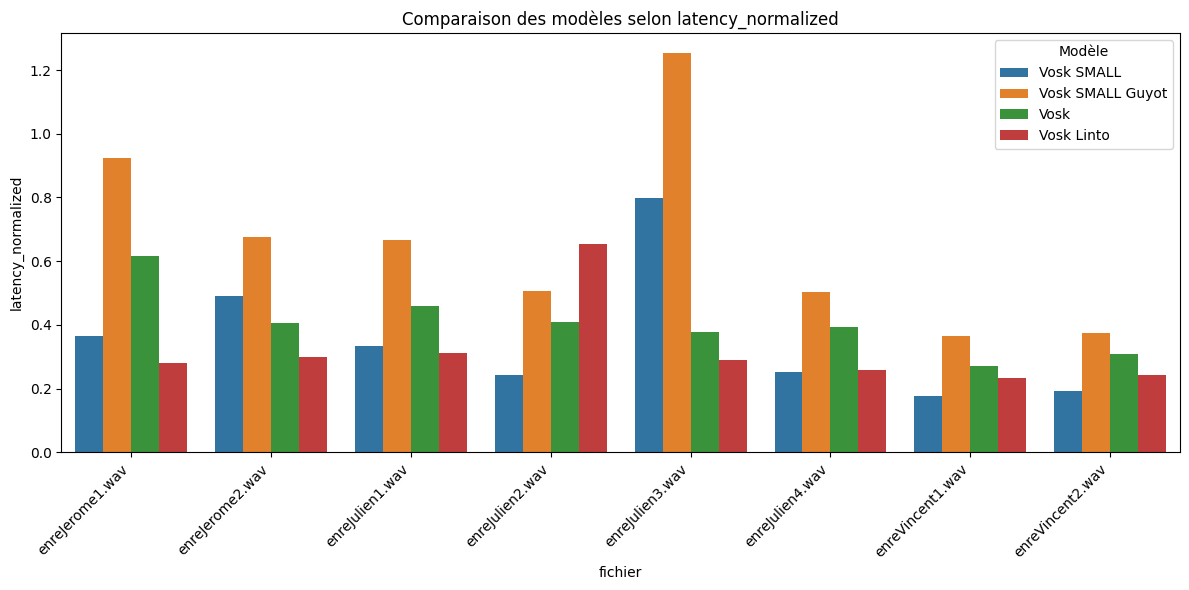

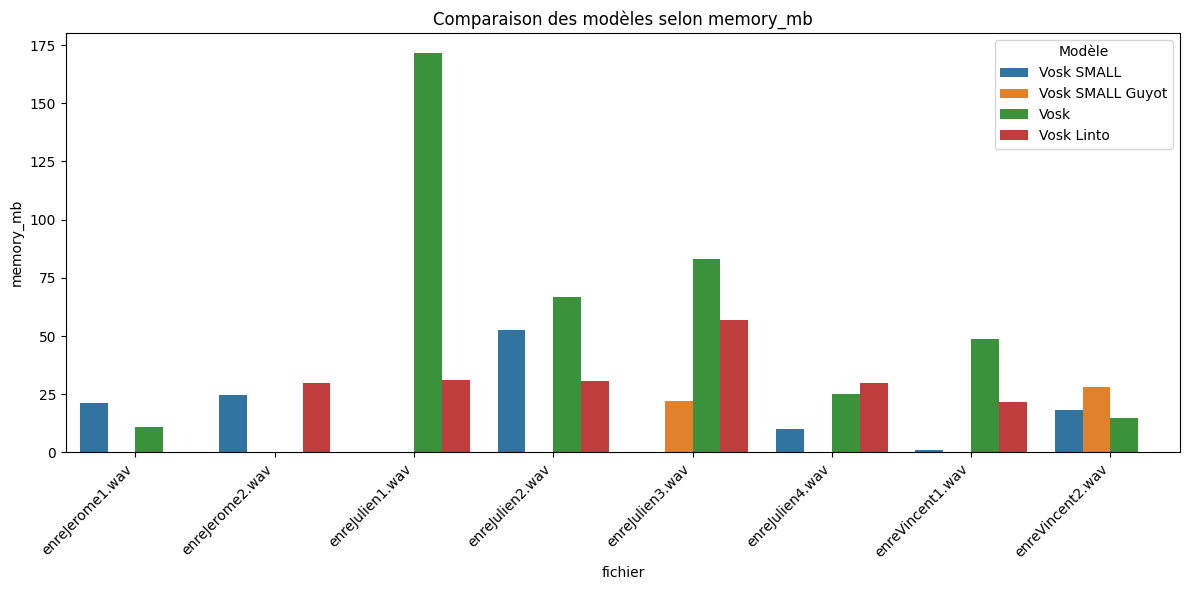

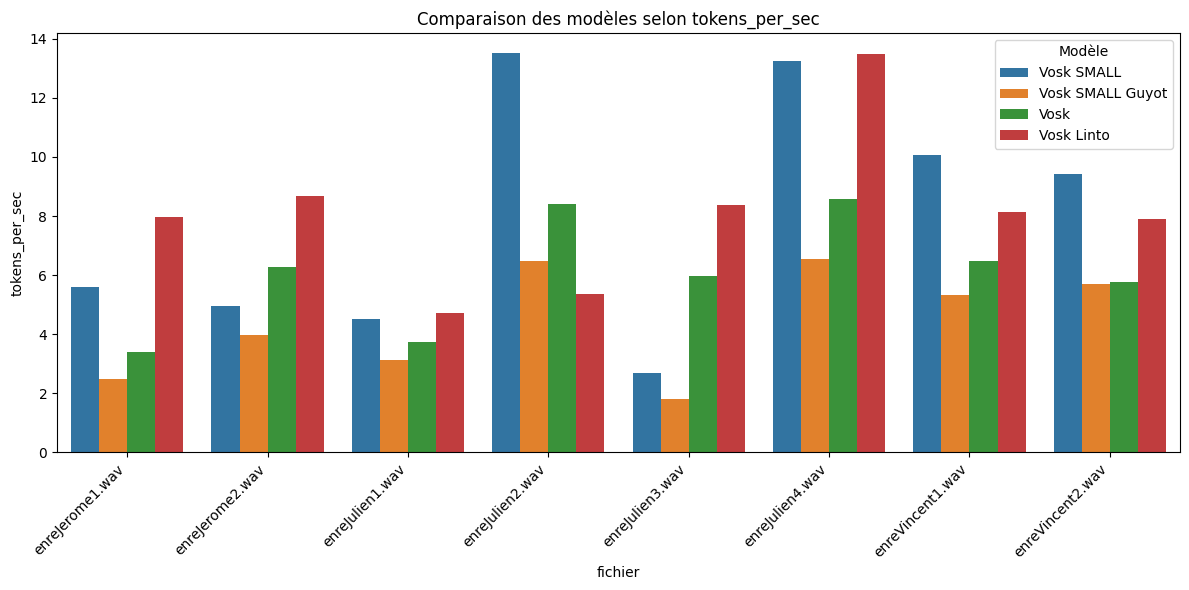

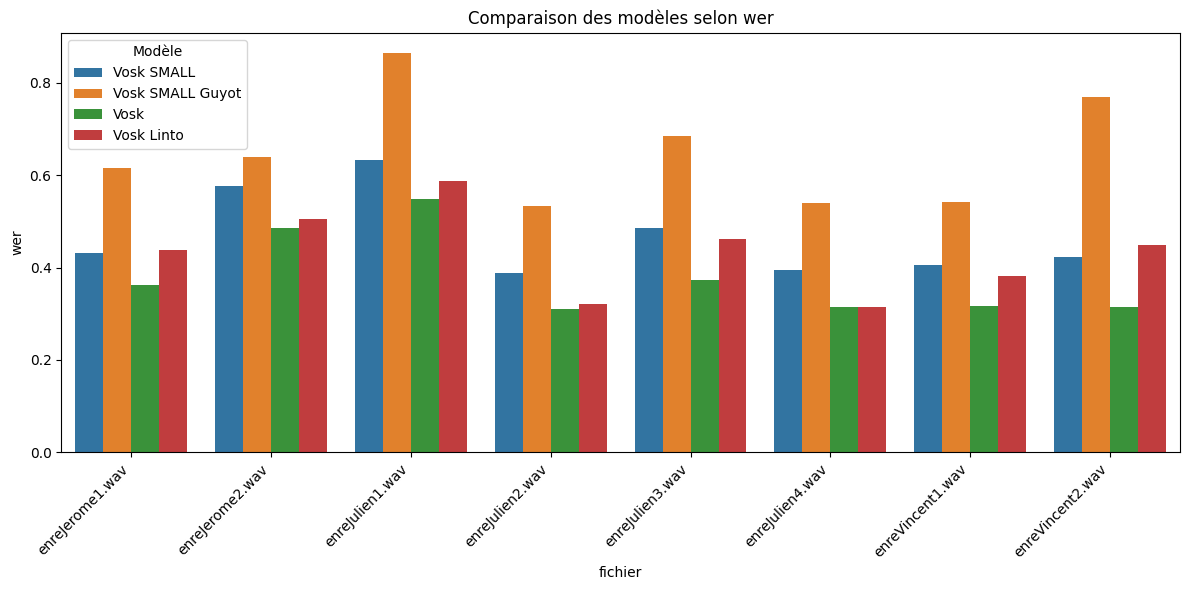

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv('transcription_performance.csv')

# Liste des modèles et des métriques à analyser
modeles = df['modele'].unique()
metrics = ['latency_normalized', 'memory_mb', 'tokens_per_sec', 'wer']

# Fonction pour tracer les graphiques de comparaison par métrique
def plot_metric(metric):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='fichier', y=metric, hue='modele')
    plt.title(f'Comparaison des modèles selon {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(title='Modèle')
    plt.show()

# Tracer un graphique pour chaque métrique
for metric in metrics:
    plot_metric(metric)



In [ ]:
import re

def verifier_nouveaux_mots(corpus_file, nouveaux_mots):
    """
    Vérifie si les mots de la liste nouveaux_mots sont présents dans le fichier words.txt de Vosk.
    Format attendu : mot index (séparés par un espace ou tabulation)
    """
    with open(corpus_file, 'r', encoding='utf-8') as infile:
        corpus = infile.read().splitlines()
    
    # Extraire uniquement les mots (première colonne)
    mots_corpus = set()
    for ligne in corpus:
        # Ignorer les lignes vides
        if ligne.strip():
            # Prendre le premier élément avant l'espace/tab
            mot = ligne.split()[0]
            mots_corpus.add(mot)
    
    # Vérifier chaque nouveau mot
    resultats = {}
    for mot in nouveaux_mots:
        resultats[mot] = mot in mots_corpus
    
    return resultats


# Fichier de vocabulaire Vosk
corpus_file = 'Vosk_Medical/graph/words.txt'

nouveaux_mots = [
    'thermo-ablation',
    'micro-ondes',
    'métastase',
    'hépatique',
    'rénale',
    'rcp',
    'échographie',
    'échographe',
    'angio-dynamique',
    'soléro',
    'aiguille',
    'xiphoïdienne',
    'watts',
    'embolisation',
    'veineuse',
    'pelvienne',
    'phlébographie',
    'gonadique',
    'french',
    'cathétériser',
    'cobra',
    'onyx',
    'truselect',
    'chirambu',
    'radiofréquence',
    'nodule',
    'pulmonaire',
    'décubitus',
    'pneumothorax',
    'biopsie',
    'adénome',
    'scopi-scan',
    'sédation',
    'microcathéter',
    'cathéter',
    'avalon',
    'xylo',
    'hdj',
    'rectorragie',
    'hémorroïdes',
    'fémoral',
    'sim1',
    'artère',
    'mésentérique',
    'inférieure',
    'microguide',
    'fathom',
    'artériographie',
    'coils',
    'nester',
    'tornado',
    'rectale',
    'iliaque',
    'interne',
    'contraste',
    'bétadine',
    'chc',
    'lipiodolé',
    'abord',
    'artériel',
    'ligament',
    'arqué',
    'hépatique',
    'droite',
    'segment',
    'schiba',
    'diaphragme',
    'artefact',
    'plexus',
    'brachial',
    'jet',
    'méopa',
    'introducteur',
    'sidewinder',
    'bern',
    'microcoils',
    'coagulation',
    'exoseal',
    'hydratation',
    'embosphère'
]


# Vérification
resultats = verifier_nouveaux_mots(corpus_file, nouveaux_mots)

# Afficher seulement les mots absents (à ajouter)
print("=" * 60)
print("MOTS À AJOUTER AU VOCABULAIRE VOSK :")
print("=" * 60)
absents = [mot for mot, present in resultats.items() if not present]
for mot in absents:
    print(f"✅ {mot}")

print(f"\n📊 Total : {len(absents)} mots à ajouter sur {len(nouveaux_mots)}")

# Afficher seulement les mots déjà présents
print("\n" + "=" * 60)
print("MOTS DÉJÀ PRÉSENTS DANS LE VOCABULAIRE :")
print("=" * 60)
presents = [mot for mot, present in resultats.items() if present]
for mot in presents:
    print(f"✔️  {mot}")

print(f"\n📊 Total : {len(presents)} mots déjà présents sur {len(nouveaux_mots)}")



MOTS À AJOUTER AU VOCABULAIRE VOSK :
✅ soléro
✅ xiphoïdienne
✅ cathétériser
✅ truselect
✅ chirambu
✅ scopi-scan
✅ microcathéter
✅ xylo
✅ hdj
✅ sim1
✅ microguide
✅ nester
✅ lipiodolé
✅ schiba
✅ méopa
✅ microcoils
✅ exoseal
✅ embosphère

📊 Total : 18 mots à ajouter sur 80

MOTS DÉJÀ PRÉSENTS DANS LE VOCABULAIRE :
✔️  thermo-ablation
✔️  micro-ondes
✔️  métastase
✔️  hépatique
✔️  rénale
✔️  rcp
✔️  échographie
✔️  échographe
✔️  angio-dynamique
✔️  aiguille
✔️  watts
✔️  embolisation
✔️  veineuse
✔️  pelvienne
✔️  phlébographie
✔️  gonadique
✔️  french
✔️  cobra
✔️  onyx
✔️  radiofréquence
✔️  nodule
✔️  pulmonaire
✔️  décubitus
✔️  pneumothorax
✔️  biopsie
✔️  adénome
✔️  sédation
✔️  cathéter
✔️  avalon
✔️  rectorragie
✔️  hémorroïdes
✔️  fémoral
✔️  artère
✔️  mésentérique
✔️  inférieure
✔️  fathom
✔️  artériographie
✔️  coils
✔️  tornado
✔️  rectale
✔️  iliaque
✔️  interne
✔️  contraste
✔️  bétadine
✔️  chc
✔️  abord
✔️  artériel
✔️  ligament
✔️  arqué
✔️  droite
✔️  segment
✔️  diap

In [6]:
import os
import time
import psutil
import csv
import json
import gc
from vosk import Model, KaldiRecognizer
import soundfile as sf
from jiwer import wer
import librosa

# ============ CONFIGURATION ============
CONFIG = {
    "VOSK_MODEL_SMALL": "vosk-model-small-fr-0.22",
    "VOSK_MODEL": "vosk-model-fr-0.22",
    "VOSK_MODEL_MEDICAL": "Vosk_Medical",
    "AUDIO_DIR": "audio_wav",
    "CSV_OUTPUT": "transcription_performance.csv",
    "SAMPLE_RATE": 16000,
    "CHUNK_SIZE": 4000
}

# Références: dictionnaire { nom_fichier: texte_reference }
REFERENCES = {
    "enreJerome1.wav": "il sagit de monsieur jeanique mohamed pour la réalisation d'une thermoablation par microondes d'une métastase épatique dorigine renale c'est une décision de rcp le patient a été vu en consultation la checkliste du bloc a été faite on va faire un guidage sous écographie on a prit l'écographe principal l'ablation va être faite avec le générateur en angiodynamique on a le générateur soléro oui une aiguille de 14 cm aiguille unique on a une poche de froid comme cest nécessaire on va faire un bord sous écho par voie sous xifoïdienne une seule aiguille bien centrée une ablation on part sur une ablation de 6 minutes à la puissance de 100 watts une fois que ce sera terminé le patient sera réveillé et normalement la sortie est prévue demain merci",    
    "enreJerome2.wav": "il sagit de madame déjésus on va faire une embolisation veineuse pelvienne on lui a déjà fait la phébographie diagnostique la semaine dernière qui a retrouvée une seule grosse veine gonadique gauche donc on va piquer en 5 french on va recathétériser avec le même matériel cobra 5 lembolisation se fera avec de lonix on a mis le flacon donyx 346 à secouer on utilisera un micro 4 truselecto une fois que ca sera fini il remontera en chirambu et on lui donnera un rendez vous de consultation à trois mois allez cest parti merci à tous",
    "enreJulien1.wav": "bonjour aujourdhui on va faire une radio fréquence dun nodule pulmonaire du lobe moyen il sagit dune métastase probablement dun cancer prostatique donc pour ce faire on va installer le patient en decobutus dorsale le geste sera fait sous anesthésie générale et on va procéder avec donc vu la localisation de la lesion on aura probablement pas besoin de faire un pneumothorax donc on pourra peutêtre prendre des balettes de 3 cm ou de 35 cm et donc on va essayer daller par un abord direct estce quon va prendre de la jet lanesthésiste demande si on prend de la jet pour ce patient je pense quon na pas besoin de prendre de la jet tu le mets comment  on demande on le met sur le dos ou sur le côté  voilà et après je te pose une question con mais est ce que je te prend le matériel de biopsie on a déjà fait une biopsie on a déjà fait  ah pardon alors juste lablation  de la radio fréquence je te ramène le materiel aller go",
    "enreJulien2.wav": "ok donc on a monsieur sanjogé george cest une embolisation de la prostate pour un patient qui a un adénome donc on part sur un geste assez classique on fera scopi scan comme on fait dhabitude donc faut bien préparer le scan patient allongé sous sédation et même je voudrais quil soit sousagé parce quaujourdhui attention soyez vigilant on va utiliser un nouveau matériel cest le micro catéter sniper cest du 27 daccord donc il est assez gros je ne sais pas si on va arriver à lamener jusquà la prostate mais je crois que le bout il est plus petit non je crois que le bout il est en 22 cest un catéter avalon qui va nous permettre dinjecter de lonyx donc comme vous le savez lonyx ça fait mal donc il faudra bien quil dorme au moment de linjection et ça ne coûtera rien de rajouter un peu de xylo quand on va injecter donc il faudra bien préparer donc vu quon veut utiliser de lonyx je vous propose de dès à présent commencer à lagiter et sinon au niveau technique donc on va rester en 4 french on va faire comme dhabitude un abord fémorale droit cest un geste que je pense quil ne va pas être trop long à mon avis il faut que dans deux heures ça soit terminé en tout cas on la prévue sur deux heures maximum et le patient derrière il est en hdj il retournera chez lui donc pensez bien faire le courrier dhdj allez go",
    "enreJulien3.wav": "bonjour tout le monde aujourdhui on va traiter madame sally fatima qui se plaint de rectoragie abondante depuis quelques mois avec anémie nécessitant des transfusions donc aujourdhui on va traiter on va emboliser les hémorroïde interne donc ce sera un abord fémoral droit en quatre franch on va prendre une sonde sim 1 pour cathétériser lartère mésentérique inférieure et après un micro cathétaire 20 ou 19 quest ce quon a en micro cathétaire  on prendra un boston 19 et on va prendre un micro guide fathome donc là on va cathétériser quest ce quil nous faut dautre  on prépare linjecteur pour faire une artérographie au niveau de lartère mésentérique inférieure et on va emboliser avec des coils et des petits coils nester ou tournado 2 mm et 3 mm donc on prépare tout ça une simple sédation suffit on na pas besoin de lanesthésie générale la patiente elle est bien consciente on discutera au fur et à mesure sil y a un souci donc après si on va déceler des branches de lartère rectal moyenne en opacifiant au niveau de lartère rectal inférieur au niveau des rectales supérieures si on décelle des rectales moyennes on va les emboliser en passant par lartère illiaque interne voilà donc faites bien la vérification que tout est bien on a besoin de la scopie de la graphie on na pas besoin de scanner et voilà on vérifie quil ny a pas dallergie au produit de contraste pas dallergie à la bétadine",
    "enreJulien4.wav": "ok donc on va soccuper de monsieur poveda donc cest un patient qui vient pour une tumeur du foie cest un chc on a déjà fait la biopsie ce chc il nest pas visible en imagerie donc il faudra quon lui fasse un marquage lipyodolé donc les manipes il faut que vous prépailliez la table pour faire un abort artériel il ny a pas de liguament arqué donc on va y aller avec une sonde cobra on fera un abort fémoral droit chez lui et on utilisera du lipyodole on prendra environ 2 cc quon mélangera avec 5 cc deau et il faudra aller dans lartérien hépatique droite pour opacifier son nodule pour être sûr quon la bien opacifié on fera un scan donc il faut préparer le scan donc il nous faudra langio et le scan un abort artériel au scan dès quon voit le nodule on lui fera un traitement percutané on va choisir des microondes cest une lésion qui est dans le segment 7 donc il faut amener laiguille de microondes elle est collée au diaphragme donc il va falloir quon décolle donc on prendra des aiguilles schibas et on prendra soit du liquide soit du co2 donc il va nous falloir du liquide du co2 quand vous allez prendre le liquide cest important de mettre un peu de contraste pas trop pour pas quil y ait dartefac donc vous mettez 1 cc à peu près pour 20 cc deau et vous ferez vu la localisation et la taille du nodule je vous propose de faire 100 watts 10 minutes donc le patient il sera sousagé bien sûr il sera en décutbitus dorsale et il faudra bien lui lever la main droite au dessus de la tête donc quand vous avez levé la main droite vous faites bien attention à son plexus brachial pour pas quitter de complication au réveil estce que vous avez bien compris  ah il y a lanesthésie ce qui me demande si on met de la jet effectivement vu que la lésion est dans le domes il faudra quon ait la jet donc vous mettez la jet au moment de lablation pas avant allez go",
    "enreVincent1.wav": "bonjour nous faisons le briefing du patient rémi dubois donc lidentité a bien été vérifiée donc il sagit dune embolisation dhémoroïdes alors nous allons installer monsieur rémi dubois en position normale dans la salle avec un échographe en place et du méopa pour lanesthésie pour réaliser lintervention jai besoin dun introducteur 4 french dune sonde sidewinder 4f dun micro cathétaire de type direction bern jutiliserai des microcoils de type micro nester 27 mm chez ce patient nous avons identifié des troubles de la coagulation il est donc nécessaire de réaliser une fermeture du point de ponction à laide dun système de fermeture type exhaustile 5f il y a par ailleurs aussi une insuffisance rénale limite donc il sera très important de limiter au maximum linjection de produit de contraste et de prévoir une hydratation après il a été également identifié une allergie au produit de contraste normalement le patient a dû être préparé pendant trois jours est ce que cette préparation médicamentale ça a bien été faite ok il ny a pas dautre facteur de risque évoqué donc on peut installer le patient",
    "enreVincent2.wav": "bonjour on attaque le briefing pour monsieur vincent vidal donc lidentité a bien été vérifiée ok donc le patient va être installé en position standard sur la table avec comme matériel disponible un écographe pour faire la ponction du méopa pour lanesthésie nous allons pratiquer une embolisation de prostate il va donc falloir faire un abort fémoral 6 french au niveau du pli inguinal droit ensuite mettre en place un cathétère guide rdc6f on fera des injections à la seringue électrique avec du produit contraste dilué à 50 jaurais besoin comme micro cathétère de type progreat avec des guides de terumo 0 0 16 inch ensuite je vais prendre comme agent dembolisation des microsphères type embosphère 500700 et des microcoil de type nester 27 mm il ny a pas de problématique identifiée très clairement chez ce patient notamment pas de problème de coagulation ou de fonction renale voilà est ce quil y a des questions particulières"
}


class VoskTranscriberManager:
    """Gestionnaire centralisé des modèles Vosk avec gestion mémoire optimisée."""

    def __init__(self, config):
        self.config = config
        self.models = {}
        self.sample_rate = config["SAMPLE_RATE"]
        self.chunk_size = config["CHUNK_SIZE"]
        self._load_models()

    def _load_models(self):
        """Charge les modèles Vosk au démarrage."""
        model_paths = {
            "small": self.config["VOSK_MODEL_SMALL"],
            "standard": self.config["VOSK_MODEL"],
            "medical": self.config["VOSK_MODEL_MEDICAL"]
        }

        for key, path in model_paths.items():
            try:
                self.models[key] = Model(path)
                print(f"✅ Modèle {key} chargé")
            except Exception as e:
                print(f"❌ Erreur lors du chargement du modèle {key}: {e}")
                self.models[key] = None

    def transcribe(self, audio_path, model_key):
        """Transcrit un fichier audio avec le modèle spécifié."""
        if self.models.get(model_key) is None:
            return ""

        rec = KaldiRecognizer(self.models[model_key], self.sample_rate)

        try:
            with sf.SoundFile(audio_path) as f:
                while True:
                    data = f.read(self.chunk_size, dtype='int16')
                    if len(data) == 0:
                        break
                    rec.AcceptWaveform(data.tobytes())

            result_json = rec.FinalResult()
            result = json.loads(result_json)
            return result.get("text", "")
        except Exception as e:
            print(f"❌ Erreur transcription: {e}")
            return ""
        finally:
            del rec
            gc.collect()

    def cleanup(self):
        """Libère les ressources."""
        self.models.clear()
        gc.collect()


class PerformanceMetrics:
    """Collecte et calcule les métriques de performance."""

    @staticmethod
    def get_audio_duration(audio_path):
        """Obtient la durée de l'audio."""
        try:
            return librosa.get_duration(path=audio_path)
        except Exception as e:
            print(f"⚠️ Erreur durée audio: {e}")
            return 1

    @staticmethod
    def measure_transcription(transcriber, audio_path, model_key):
        """Mesure les performances de transcription."""
        process = psutil.Process()

        mem_before = process.memory_info().rss / 1024 / 1024
        time_start = time.time()

        transcript = transcriber.transcribe(audio_path, model_key)

        time_end = time.time()
        mem_after = process.memory_info().rss / 1024 / 1024

        return {
            "transcript": transcript,
            "latency_sec": time_end - time_start,
            "memory_mb": max(mem_after - mem_before, 0)
        }

    @staticmethod
    def count_tokens(text):
        """Compte le nombre de tokens (mots)."""
        return len(text.split()) if text else 0

    @staticmethod
    def calculate_metrics(transcript, reference_text, latency, memory, audio_duration):
        """Calcule tous les métriques normalisées."""
        tokens = PerformanceMetrics.count_tokens(transcript)

        return {
            "latency_per_sec": latency / audio_duration if audio_duration > 0 else -1,
            "latency_per_token": latency / tokens if tokens > 0 else -1,
            "memory_per_sec": memory / audio_duration if audio_duration > 0 else -1,
            "memory_per_token": memory / tokens if tokens > 0 else -1,
            "tokens": tokens,
            "tokens_per_sec": tokens / latency if latency > 0 else -1,
            "wer": wer(reference_text, transcript) if reference_text else -1
        }


class CSVResultsWriter:
    """Gère l'écriture des résultats en CSV."""

    FIELDNAMES = [
        "fichier", "modele", "latency_sec", "memory_mb", "duration_sec",
        "latency_per_sec", "latency_per_token", "memory_per_sec",
        "memory_per_token", "tokens", "tokens_per_sec", "wer", "transcript"
    ]

    def __init__(self, output_path):
        self.output_path = output_path
        self.csvfile = None
        self.writer = None
        self._initialize()

    def _initialize(self):
        """Initialise le fichier CSV avec les en-têtes."""
        self.csvfile = open(self.output_path, "w", newline="", encoding="utf-8")
        self.writer = csv.DictWriter(self.csvfile, fieldnames=self.FIELDNAMES)
        self.writer.writeheader()

    def write_row(self, row_data):
        """Écrit une ligne dans le CSV."""
        self.writer.writerow(row_data)
        self.csvfile.flush()

    def close(self):
        """Ferme le fichier CSV."""
        if self.csvfile:
            self.csvfile.close()


class AudioBenchmark:
    """Orchestrateur principal du benchmark."""

    def __init__(self, config, references):
        self.config = config
        self.references = references
        self.transcriber = VoskTranscriberManager(config)
        self.metrics = PerformanceMetrics()
        self.models_to_test = ["small", "standard", "medical"]

    def process_audio_file(self, filename, csv_writer):
        """Traite un fichier audio avec tous les modèles."""
        audio_path = os.path.join(self.config["AUDIO_DIR"], filename)
        audio_duration = self.metrics.get_audio_duration(audio_path)
        reference_text = self.references.get(filename, "")

        print(f"\n{'='*60}")
        print(f"🌟 Traitement: {filename}")
        print(f"{'='*60}")

        for model_key in self.models_to_test:
            model_name = self._get_model_display_name(model_key)
            print(f"▶️  Transcription avec {model_name}...", end=" ", flush=True)

            try:
                # Mesure la performance
                perf_data = self.metrics.measure_transcription(
                    self.transcriber, audio_path, model_key
                )

                # Calcule les métriques normalisées
                metrics_data = self.metrics.calculate_metrics(
                    perf_data["transcript"],
                    reference_text,
                    perf_data["latency_sec"],
                    perf_data["memory_mb"],
                    audio_duration
                )

                # Prépare la ligne CSV
                row_data = {
                    "fichier": filename,
                    "modele": model_name,
                    "latency_sec": perf_data["latency_sec"],
                    "memory_mb": perf_data["memory_mb"],
                    "duration_sec": audio_duration,
                    "latency_per_sec": metrics_data["latency_per_sec"],
                    "latency_per_token": metrics_data["latency_per_token"],
                    "memory_per_sec": metrics_data["memory_per_sec"],
                    "memory_per_token": metrics_data["memory_per_token"],
                    "tokens": metrics_data["tokens"],
                    "tokens_per_sec": metrics_data["tokens_per_sec"],
                    "wer": metrics_data["wer"],
                    "transcript": perf_data["transcript"]
                }

                csv_writer.write_row(row_data)

                print(f"✅ {perf_data['latency_sec']:.2f}s | WER: {metrics_data['wer']:.3f}")

            except Exception as e:
                print(f"❌ Erreur: {e}")

    @staticmethod
    def _get_model_display_name(model_key):
        """Retourne le nom d'affichage du modèle."""
        names = {"small": "Vosk SMALL", "standard": "Vosk", "medical": "Vosk_Medical"}
        return names.get(model_key, model_key)

    def run(self):
        """Lance le benchmark complet."""
        csv_writer = CSVResultsWriter(self.config["CSV_OUTPUT"])

        try:
            # Récupère les fichiers audio
            audio_files = [f for f in os.listdir(self.config["AUDIO_DIR"]) 
                          if f.lower().endswith(".wav")]

            print(f"\n📁 {len(audio_files)} fichier(s) trouvé(s)")

            # Traite chaque fichier
            for audio_file in audio_files:
                self.process_audio_file(audio_file, csv_writer)

            print(f"\n{'='*60}")
            print(f"✅ Benchmark terminé - Résultats sauvegardés: {self.config['CSV_OUTPUT']}")
            print(f"{'='*60}\n")

        finally:
            csv_writer.close()
            self.transcriber.cleanup()


def main():
    """Point d'entrée du programme."""
    benchmark = AudioBenchmark(CONFIG, REFERENCES)
    benchmark.run()


if __name__ == "__main__":
    main()

✅ Modèle small chargé
✅ Modèle standard chargé
✅ Modèle medical chargé

📁 8 fichier(s) trouvé(s)

🌟 Traitement: enreJerome1.wav
▶️  Transcription avec Vosk SMALL... ✅ 22.86s | WER: 0.446
▶️  Transcription avec Vosk... ✅ 27.50s | WER: 0.362
▶️  Transcription avec Vosk_Medical... 

: 

In [5]:
import string

REFERENCES = {
    "enreJerome1.wav": "Il s'agit de M. Jeanique Mohamed pour la réalisation d'une thermo-ablation par micro-ondes d'une métastase épatique d'origine renale, c'est une décision de RCP, le patient a été vu en consultation. La checkliste du bloc a été faite. On va faire un guidage sous écographie, on a prit l'écographe principal. L'ablation va être faite avec le générateur en angio-dynamique. On a le générateur soléro, oui. Une aiguille de 14 cm, aiguille unique. On a une poche de froid comme c'est nécessaire, on va faire un bord sous écho par voie sous xifoïdienne, une seule aiguille bien centrée, une ablation, on part sur une ablation de 6 minutes à la puissance de 100 watts. Une fois que ce sera terminé, le patient sera réveillé et normalement la sortie est prévue demain. Merci. ",
    "enreJerome2.wav": "Il s'agit de madame Déjésus, on va faire une embolisation veineuse pelvienne, on lui a déjà fait la phébographie diagnostique la semaine dernière qui a retrouvée une seule grosse veine gonadique gauche, donc on va piquer en 5 french, on va recathétériser avec le même matériel cobra 5, l'embolisation se fera avec de l'ONIX, on a mis le flacon d'ONYX 34-6 à secouer, on utilisera un micro 4 TRUSELECTO Une fois que ca sera fini, il remontera en chirambu et on lui donnera un rendez-vous de consultation à trois mois. Allez c'est parti, merci à tous. ",
    "enreJulien1.wav": "Bonjour, aujourd'hui on va faire une radio fréquence d'un nodule pulmonaire du lobe moyen, il s'agit d'une métastase probablement d'un cancer prostatique. Donc pour ce faire on va installer le patient en decobutus dorsale. Le geste sera fait sous anesthésie générale et on va procéder avec, donc vu la localisation de la lesion on aura probablement pas besoin de faire un pneumothorax, donc on pourra peut-être prendre des balettes de 3 cm ou de 3,5 cm et donc on va essayer d'aller par un abord direct. Est-ce qu'on va prendre de la jet? L'anesthésiste demande si on prend de la jet. Pour ce patient je pense qu'on n'a pas besoin de prendre de la jet. Tu le mets comment ? On demande, on le met sur le dos ou sur le côté ? Voilà et après. Je te pose une question con mais est ce que je te prend le matériel de biopsie. On a déjà fait une biopsie. On a déjà fait ? Ah pardon. Alors juste l'ablation. ... de la radio fréquence? Je te ramène le materiel. Aller go! ",
    "enreJulien2.wav": "Ok donc on a monsieur Sanjogé George, c'est une embolisation de la prostate pour un patient qui a un adénome. Donc on part sur un geste assez classique, on fera scopi scan comme on fait d'habitude, donc faut bien préparer le scan, patient allongé, sous sédation. Et même je voudrais qu'il soit sous-agé parce qu'aujourd'hui, attention, soyez vigilant, on va utiliser un nouveau matériel. C'est le micro catéter sniper, c'est du 2.7, d'accord donc il est assez gros, je ne sais pas si on va arriver à l'amener jusqu'à la prostate. Mais je crois que le bout il est plus petit, non, je crois que le bout il est en 2.2. C'est un catéter avalon qui va nous permettre d'injecter de l'onyx, donc comme vous le savez l'onyx ça fait mal. Donc il faudra bien qu'il dorme au moment de l'injection et ça ne coûtera rien de rajouter un peu de xylo quand on va injecter. Donc il faudra bien préparer, donc vu qu'on veut utiliser de l'onyx, je vous propose de dès à présent, commencer à l'agiter. Et sinon au niveau technique, donc on va rester en 4 French, on va faire comme d'habitude un abord fémorale droit. C'est un geste que je pense qu'il ne va pas être trop long, à mon avis il faut que dans deux heures ça soit terminé en tout cas on la prévue sur deux heures maximum. Et le patient derrière, il est en HDJ, il retournera chez lui, donc pensez bien faire le courrier d'HDJ. Allez go!",
    "enreJulien3.wav": "Bonjour tout le monde, aujourd'hui on va traiter madame Sally Fatima qui se plaint de rectoragie abondante depuis quelques mois avec anémie nécessitant des transfusions. Donc aujourd'hui on va traiter, on va emboliser les hémorroïde interne donc ce sera un abord fémoral droit en quatre franch. On va prendre une sonde SIM 1 pour cathétériser l'artère mésentérique inférieure et après un micro cathétaire 2.0 ou 1.9. Qu'est ce qu'on a en micro cathétaire ? On prendra un Boston 1.9 et on va prendre un micro guide Fathome. Donc là on va cathétériser qu'est ce qu'il nous faut d'autre ? On prépare l'injecteur pour faire une artérographie au niveau de l'artère mésentérique inférieure et on va emboliser avec des coils et des petits coils nester ou tournado 2 mm et 3 mm. Donc on prépare tout ça. Une simple sédation suffit, on n'a pas besoin de l'anesthésie générale. La patiente elle est bien consciente, on discutera au fur et à mesure s'il y a un souci. Donc après si on va déceler des branches de l'artère rectal moyenne en opacifiant au niveau de l'artère rectal inférieur au niveau des rectales supérieures. Si on décelle des rectales moyennes, on va les emboliser en passant par l'artère illiaque interne. Voilà donc faites bien la vérification que tout est bien, on a besoin de la scopie, de la graphie, on n'a pas besoin de scanner. Et voilà, on vérifie qu'il n'y a pas d'allergie au produit de contraste, pas d'allergie à la bétadine.",
    "enreJulien4.wav": "Ok, donc on va s'occuper de monsieur Poveda, donc c'est un patient qui vient pour une tumeur du foie, c'est un CHC, on a déjà fait la biopsie, ce CHC il n'est pas visible en imagerie, donc il faudra qu'on lui fasse un marquage lipyodolé, donc les manipes, il faut que vous prépailliez la table pour faire un abort artériel, il n'y a pas de liguament arqué, donc on va y aller avec une sonde Cobra, on fera un abort fémoral droit chez lui et on utilisera du lipyodole, on prendra environ 2 CC qu'on mélangera avec 5 CC d'eau et il faudra aller dans l'artérien hépatique droite pour opacifier son nodule, pour être sûr qu'on l'a bien opacifié, on fera un scan, donc il faut préparer le scan, donc il nous faudra l'angio et le scan, un abort artériel. Au scan, dès qu'on voit le nodule, on lui fera un traitement percutané, on va choisir des micro-ondes, c'est une lésion qui est dans le segment 7, donc il faut amener l'aiguille de micro-ondes, elle est collée au diaphragme, donc il va falloir qu'on décolle, donc on prendra des aiguilles schibas et on prendra soit du liquide soit du CO2, donc il va nous falloir du liquide du CO2. Quand vous allez prendre le liquide, c'est important de mettre un peu de contraste, pas trop pour pas qu'il y ait d'artefac, donc vous mettez 1 CC à peu près pour 20 CC d'eau et vous ferez, vu la localisation et la taille du nodule, je vous propose de faire 100 watts 10 minutes. Donc le patient il sera sous-agé bien sûr, il sera en décutbitus dorsale et il faudra bien lui lever la main droite au dessus de la tête, donc quand vous avez levé la main droite, vous faites bien attention à son plexus brachial pour pas quitter de complication au réveil. Est-ce que vous avez bien compris ? Ah il y a l'anesthésie ce qui me demande si on met de la jet, effectivement vu que la lésion est dans le domes, il faudra qu'on ait la jet, donc vous mettez la jet au moment de l'ablation, pas avant. Allez go !",
    "enreVincent1.wav": "bonjour nous faisons le briefing du patient Rémi Dubois donc l'identité a bien été vérifiée donc il s'agit d'une embolisation d'hémoroïdes alors nous allons installer monsieur Rémi Dubois en position normale dans la salle avec un échographe en place et du méopa pour l'anesthésie pour réaliser l'intervention j'ai besoin d'un introducteur 4 French d'une sonde Sidewinder 4F d'un micro cathétaire de type direction Bern j'utiliserai des micro-coils de type micro nester 2-7 mm chez ce patient nous avons identifié des troubles de la coagulation il est donc nécessaire de réaliser une fermeture du point de ponction à l'aide d'un système de fermeture type exhaustile 5F il y a par ailleurs aussi une insuffisance rénale limite donc il sera très important de limiter au maximum l'injection de produit de contraste et de prévoir une hydratation après il a été également identifié une allergie au produit de contraste normalement le patient a dû être préparé pendant trois jours est ce que cette préparation médicamentale ça a bien été faite ok il n'y a pas d'autre facteur de risque évoqué donc on peut installer le patient",
    "enreVincent2.wav": "Bonjour on attaque le briefing pour monsieur Vincent Vidal donc l'identité a bien été vérifiée ok donc le patient va être installé en position standard sur la table avec comme matériel disponible un écographe pour faire la ponction du méopa pour l'anesthésie nous allons pratiquer une embolisation de prostate il va donc falloir faire un abort fémoral 6 French au niveau du pli inguinal droit ensuite mettre en place un cathétère guide RDC6F on fera des injections à la seringue électrique avec du produit contraste dilué à 50% j'aurais besoin comme micro cathétère de type Progreat avec des guides de Terumo 0 0 16 inch ensuite je vais prendre comme agent d'embolisation des microsphères type embosphère 500-700 et des micro-coil de type nester 2-7 mm il n'y a pas de problématique identifiée très clairement chez ce patient notamment pas de problème de coagulation ou de fonction renale. Voilà. est ce qu'il y a des questions particulières ? "
}


def normalize_text(text):
    """Supprime la ponctuation et convertit en minuscules."""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Normaliser toutes les références
REFERENCES_NORMALIZED = {
    filename: normalize_text(text)
    for filename, text in REFERENCES.items()
}
# Afficher les exemples normalisés
for filename, text in REFERENCES_NORMALIZED.items():
    print(f"{filename}:\n{text}\n")

enreJerome1.wav:
il sagit de m jeanique mohamed pour la réalisation dune thermoablation par microondes dune métastase épatique dorigine renale cest une décision de rcp le patient a été vu en consultation la checkliste du bloc a été faite on va faire un guidage sous écographie on a prit lécographe principal lablation va être faite avec le générateur en angiodynamique on a le générateur soléro oui une aiguille de 14 cm aiguille unique on a une poche de froid comme cest nécessaire on va faire un bord sous écho par voie sous xifoïdienne une seule aiguille bien centrée une ablation on part sur une ablation de 6 minutes à la puissance de 100 watts une fois que ce sera terminé le patient sera réveillé et normalement la sortie est prévue demain merci 

enreJerome2.wav:
il sagit de madame déjésus on va faire une embolisation veineuse pelvienne on lui a déjà fait la phébographie diagnostique la semaine dernière qui a retrouvée une seule grosse veine gonadique gauche donc on va piquer en 5 french

In [1]:
import os
import time
import psutil
import csv
import json
import gc
import string
from vosk import Model, KaldiRecognizer
import soundfile as sf
from jiwer import wer
import librosa

CONFIG = {
    "VOSK_MODEL_SMALL": "vosk-model-small-fr-0.22",
    "VOSK_MODEL": "vosk-model-fr-0.22",
    "VOSK_MODEL_MEDICAL": "Vosk_Medical",
    "AUDIO_DIR": "audio_wav",
    "CSV_OUTPUT": "transcription_performance.csv",
    "SAMPLE_RATE": 16000,
    "CHUNK_SIZE": 4000
}

class VoskTranscriberManager:
    """Gestionnaire Vosk avec déchargement mémoire après chaque modèle."""

    def __init__(self, config):
        self.config = config
        self.models = {}
        self.sample_rate = config["SAMPLE_RATE"]
        self.chunk_size = config["CHUNK_SIZE"]
        self.loaded_model_key = None

    def _load_model(self, model_key):
        """Charge UN seul modèle à la fois."""
        if self.loaded_model_key == model_key and model_key in self.models:
            return  # Déjà chargé
        
        # Décharger le modèle précédent
        if self.loaded_model_key in self.models:
            del self.models[self.loaded_model_key]
            gc.collect()
        
        model_paths = {
            "small": self.config["VOSK_MODEL_SMALL"],
            "standard": self.config["VOSK_MODEL"],
            "medical": self.config["VOSK_MODEL_MEDICAL"]
        }
        
        try:
            print(f"  Chargement du modèle {model_key}...", end=" ", flush=True)
            self.models[model_key] = Model(model_paths[model_key])
            self.loaded_model_key = model_key
            print(f"✓ Fait")
        except Exception as e:
            print(f"❌ Erreur: {e}")
            self.models[model_key] = None

    def transcribe(self, audio_path, model_key):
        """Transcrit avec gestion mémoire strict."""
        self._load_model(model_key)
        
        if self.models.get(model_key) is None:
            return ""

        rec = KaldiRecognizer(self.models[model_key], self.sample_rate)

        try:
            with sf.SoundFile(audio_path) as f:
                while True:
                    data = f.read(self.chunk_size, dtype='int16')
                    if len(data) == 0:
                        break
                    rec.AcceptWaveform(data.tobytes())

            result_json = rec.FinalResult()
            result = json.loads(result_json)
            return result.get("text", "")
        except Exception as e:
            print(f"❌ Erreur transcription: {e}")
            return ""
        finally:
            del rec
            gc.collect()

    def cleanup(self):
        """Libère toutes les ressources."""
        if self.loaded_model_key in self.models:
            del self.models[self.loaded_model_key]
        self.models.clear()
        gc.collect()


class PerformanceMetrics:
    """Collecte et calcule les métriques."""

    @staticmethod
    def get_audio_duration(audio_path):
        try:
            return librosa.get_duration(path=audio_path)
        except Exception as e:
            print(f"⚠️ Erreur durée: {e}")
            return 1

    @staticmethod
    def measure_transcription(transcriber, audio_path, model_key):
        process = psutil.Process()

        mem_before = process.memory_info().rss / 1024 / 1024
        time_start = time.time()

        transcript = transcriber.transcribe(audio_path, model_key)

        time_end = time.time()
        mem_after = process.memory_info().rss / 1024 / 1024

        return {
            "transcript": transcript,
            "latency_sec": time_end - time_start,
            "memory_mb": max(mem_after - mem_before, 0)
        }

    @staticmethod
    def count_tokens(text):
        return len(text.split()) if text else 0

    @staticmethod
    def calculate_metrics(transcript, reference_text, latency, memory, audio_duration):
        tokens = PerformanceMetrics.count_tokens(transcript)

        return {
            "latency_per_sec": latency / audio_duration if audio_duration > 0 else -1,
            "latency_per_token": latency / tokens if tokens > 0 else -1,
            "memory_per_sec": memory / audio_duration if audio_duration > 0 else -1,
            "memory_per_token": memory / tokens if tokens > 0 else -1,
            "tokens": tokens,
            "tokens_per_sec": tokens / latency if latency > 0 else -1,
            "wer": wer(reference_text, transcript) if reference_text else -1
        }


class CSVResultsWriter:
    """Écrit les résultats en CSV."""

    FIELDNAMES = [
        "fichier", "modele", "latency_sec", "memory_mb", "duration_sec",
        "latency_per_sec", "latency_per_token", "memory_per_sec",
        "memory_per_token", "tokens", "tokens_per_sec", "wer", "transcript"
    ]

    def __init__(self, output_path):
        self.output_path = output_path
        self.csvfile = open(output_path, "w", newline="", encoding="utf-8")
        self.writer = csv.DictWriter(self.csvfile, fieldnames=self.FIELDNAMES)
        self.writer.writeheader()

    def write_row(self, row_data):
        self.writer.writerow(row_data)
        self.csvfile.flush()

    def close(self):
        if self.csvfile:
            self.csvfile.close()


class AudioBenchmark:
    """Orchestrateur principal."""

    def __init__(self, config, references):
        self.config = config
        self.references = references
        self.transcriber = VoskTranscriberManager(config)
        self.metrics = PerformanceMetrics()
        self.models_to_test = ["small", "standard", "medical"]

    def process_audio_file(self, filename, csv_writer):
        audio_path = os.path.join(self.config["AUDIO_DIR"], filename)
        audio_duration = self.metrics.get_audio_duration(audio_path)
        reference_text = self.references.get(filename, "")

        print(f"\n{'='*60}")
        print(f"🌟 Traitement: {filename}")
        print(f"{'='*60}")

        for model_key in self.models_to_test:
            model_name = self._get_model_display_name(model_key)
            print(f"▶️  {model_name}...", end=" ", flush=True)

            try:
                perf_data = self.metrics.measure_transcription(
                    self.transcriber, audio_path, model_key
                )

                metrics_data = self.metrics.calculate_metrics(
                    perf_data["transcript"],
                    reference_text,
                    perf_data["latency_sec"],
                    perf_data["memory_mb"],
                    audio_duration
                )

                row_data = {
                    "fichier": filename,
                    "modele": model_name,
                    "latency_sec": perf_data["latency_sec"],
                    "memory_mb": perf_data["memory_mb"],
                    "duration_sec": audio_duration,
                    "latency_per_sec": metrics_data["latency_per_sec"],
                    "latency_per_token": metrics_data["latency_per_token"],
                    "memory_per_sec": metrics_data["memory_per_sec"],
                    "memory_per_token": metrics_data["memory_per_token"],
                    "tokens": metrics_data["tokens"],
                    "tokens_per_sec": metrics_data["tokens_per_sec"],
                    "wer": metrics_data["wer"],
                    "transcript": perf_data["transcript"]
                }

                csv_writer.write_row(row_data)
                print(f"✅ {perf_data['latency_sec']:.2f}s | WER: {metrics_data['wer']:.3f}")

            except Exception as e:
                print(f"❌ {e}")

    @staticmethod
    def _get_model_display_name(model_key):
        names = {"small": "Vosk SMALL", "standard": "Vosk", "medical": "Vosk_Medical"}
        return names.get(model_key, model_key)

    def run(self):
        csv_writer = CSVResultsWriter(self.config["CSV_OUTPUT"])

        try:
            audio_files = [f for f in os.listdir(self.config["AUDIO_DIR"]) 
                          if f.lower().endswith(".wav")]

            print(f"\n📁 {len(audio_files)} fichier(s) trouvé(s)")

            for audio_file in audio_files:
                self.process_audio_file(audio_file, csv_writer)

            print(f"\n{'='*60}")
            print(f"✅ Terminé - Résultats: {self.config['CSV_OUTPUT']}")
            print(f"{'='*60}\n")

        finally:
            csv_writer.close()
            self.transcriber.cleanup()


# Ajouter vos REFERENCES ici
REFERENCES = {
    "enreJerome1.wav": "il sagit de monsieur jeanique mohamed pour la réalisation d'une thermoablation par microondes d'une métastase épatique dorigine renale c'est une décision de rcp le patient a été vu en consultation la checkliste du bloc a été faite on va faire un guidage sous écographie on a prit l'écographe principal l'ablation va être faite avec le générateur en angiodynamique on a le générateur soléro oui une aiguille de 14 cm aiguille unique on a une poche de froid comme cest nécessaire on va faire un bord sous écho par voie sous xifoïdienne une seule aiguille bien centrée une ablation on part sur une ablation de 6 minutes à la puissance de 100 watts une fois que ce sera terminé le patient sera réveillé et normalement la sortie est prévue demain merci",    
    "enreJerome2.wav": "il sagit de madame déjésus on va faire une embolisation veineuse pelvienne on lui a déjà fait la phébographie diagnostique la semaine dernière qui a retrouvée une seule grosse veine gonadique gauche donc on va piquer en 5 french on va recathétériser avec le même matériel cobra 5 lembolisation se fera avec de lonix on a mis le flacon donyx 346 à secouer on utilisera un micro 4 truselecto une fois que ca sera fini il remontera en chirambu et on lui donnera un rendez vous de consultation à trois mois allez cest parti merci à tous",
    "enreJulien1.wav": "bonjour aujourdhui on va faire une radio fréquence dun nodule pulmonaire du lobe moyen il sagit dune métastase probablement dun cancer prostatique donc pour ce faire on va installer le patient en decobutus dorsale le geste sera fait sous anesthésie générale et on va procéder avec donc vu la localisation de la lesion on aura probablement pas besoin de faire un pneumothorax donc on pourra peutêtre prendre des balettes de 3 cm ou de 35 cm et donc on va essayer daller par un abord direct estce quon va prendre de la jet lanesthésiste demande si on prend de la jet pour ce patient je pense quon na pas besoin de prendre de la jet tu le mets comment  on demande on le met sur le dos ou sur le côté  voilà et après je te pose une question con mais est ce que je te prend le matériel de biopsie on a déjà fait une biopsie on a déjà fait  ah pardon alors juste lablation  de la radio fréquence je te ramène le materiel aller go",
    "enreJulien2.wav": "ok donc on a monsieur sanjogé george cest une embolisation de la prostate pour un patient qui a un adénome donc on part sur un geste assez classique on fera scopi scan comme on fait dhabitude donc faut bien préparer le scan patient allongé sous sédation et même je voudrais quil soit sousagé parce quaujourdhui attention soyez vigilant on va utiliser un nouveau matériel cest le micro catéter sniper cest du 27 daccord donc il est assez gros je ne sais pas si on va arriver à lamener jusquà la prostate mais je crois que le bout il est plus petit non je crois que le bout il est en 22 cest un catéter avalon qui va nous permettre dinjecter de lonyx donc comme vous le savez lonyx ça fait mal donc il faudra bien quil dorme au moment de linjection et ça ne coûtera rien de rajouter un peu de xylo quand on va injecter donc il faudra bien préparer donc vu quon veut utiliser de lonyx je vous propose de dès à présent commencer à lagiter et sinon au niveau technique donc on va rester en 4 french on va faire comme dhabitude un abord fémorale droit cest un geste que je pense quil ne va pas être trop long à mon avis il faut que dans deux heures ça soit terminé en tout cas on la prévue sur deux heures maximum et le patient derrière il est en hdj il retournera chez lui donc pensez bien faire le courrier dhdj allez go",
    "enreJulien3.wav": "bonjour tout le monde aujourdhui on va traiter madame sally fatima qui se plaint de rectoragie abondante depuis quelques mois avec anémie nécessitant des transfusions donc aujourdhui on va traiter on va emboliser les hémorroïde interne donc ce sera un abord fémoral droit en quatre franch on va prendre une sonde sim 1 pour cathétériser lartère mésentérique inférieure et après un micro cathétaire 20 ou 19 quest ce quon a en micro cathétaire  on prendra un boston 19 et on va prendre un micro guide fathome donc là on va cathétériser quest ce quil nous faut dautre  on prépare linjecteur pour faire une artérographie au niveau de lartère mésentérique inférieure et on va emboliser avec des coils et des petits coils nester ou tournado 2 mm et 3 mm donc on prépare tout ça une simple sédation suffit on na pas besoin de lanesthésie générale la patiente elle est bien consciente on discutera au fur et à mesure sil y a un souci donc après si on va déceler des branches de lartère rectal moyenne en opacifiant au niveau de lartère rectal inférieur au niveau des rectales supérieures si on décelle des rectales moyennes on va les emboliser en passant par lartère illiaque interne voilà donc faites bien la vérification que tout est bien on a besoin de la scopie de la graphie on na pas besoin de scanner et voilà on vérifie quil ny a pas dallergie au produit de contraste pas dallergie à la bétadine",
    "enreJulien4.wav": "ok donc on va soccuper de monsieur poveda donc cest un patient qui vient pour une tumeur du foie cest un chc on a déjà fait la biopsie ce chc il nest pas visible en imagerie donc il faudra quon lui fasse un marquage lipyodolé donc les manipes il faut que vous prépailliez la table pour faire un abort artériel il ny a pas de liguament arqué donc on va y aller avec une sonde cobra on fera un abort fémoral droit chez lui et on utilisera du lipyodole on prendra environ 2 cc quon mélangera avec 5 cc deau et il faudra aller dans lartérien hépatique droite pour opacifier son nodule pour être sûr quon la bien opacifié on fera un scan donc il faut préparer le scan donc il nous faudra langio et le scan un abort artériel au scan dès quon voit le nodule on lui fera un traitement percutané on va choisir des microondes cest une lésion qui est dans le segment 7 donc il faut amener laiguille de microondes elle est collée au diaphragme donc il va falloir quon décolle donc on prendra des aiguilles schibas et on prendra soit du liquide soit du co2 donc il va nous falloir du liquide du co2 quand vous allez prendre le liquide cest important de mettre un peu de contraste pas trop pour pas quil y ait dartefac donc vous mettez 1 cc à peu près pour 20 cc deau et vous ferez vu la localisation et la taille du nodule je vous propose de faire 100 watts 10 minutes donc le patient il sera sousagé bien sûr il sera en décutbitus dorsale et il faudra bien lui lever la main droite au dessus de la tête donc quand vous avez levé la main droite vous faites bien attention à son plexus brachial pour pas quitter de complication au réveil estce que vous avez bien compris  ah il y a lanesthésie ce qui me demande si on met de la jet effectivement vu que la lésion est dans le domes il faudra quon ait la jet donc vous mettez la jet au moment de lablation pas avant allez go",
    "enreVincent1.wav": "bonjour nous faisons le briefing du patient rémi dubois donc lidentité a bien été vérifiée donc il sagit dune embolisation dhémoroïdes alors nous allons installer monsieur rémi dubois en position normale dans la salle avec un échographe en place et du méopa pour lanesthésie pour réaliser lintervention jai besoin dun introducteur 4 french dune sonde sidewinder 4f dun micro cathétaire de type direction bern jutiliserai des microcoils de type micro nester 27 mm chez ce patient nous avons identifié des troubles de la coagulation il est donc nécessaire de réaliser une fermeture du point de ponction à laide dun système de fermeture type exhaustile 5f il y a par ailleurs aussi une insuffisance rénale limite donc il sera très important de limiter au maximum linjection de produit de contraste et de prévoir une hydratation après il a été également identifié une allergie au produit de contraste normalement le patient a dû être préparé pendant trois jours est ce que cette préparation médicamentale ça a bien été faite ok il ny a pas dautre facteur de risque évoqué donc on peut installer le patient",
    "enreVincent2.wav": "bonjour on attaque le briefing pour monsieur vincent vidal donc lidentité a bien été vérifiée ok donc le patient va être installé en position standard sur la table avec comme matériel disponible un écographe pour faire la ponction du méopa pour lanesthésie nous allons pratiquer une embolisation de prostate il va donc falloir faire un abort fémoral 6 french au niveau du pli inguinal droit ensuite mettre en place un cathétère guide rdc6f on fera des injections à la seringue électrique avec du produit contraste dilué à 50 jaurais besoin comme micro cathétère de type progreat avec des guides de terumo 0 0 16 inch ensuite je vais prendre comme agent dembolisation des microsphères type embosphère 500700 et des microcoil de type nester 27 mm il ny a pas de problématique identifiée très clairement chez ce patient notamment pas de problème de coagulation ou de fonction renale voilà est ce quil y a des questions particulières"
}


def main():
    benchmark = AudioBenchmark(CONFIG, REFERENCES)
    benchmark.run()


if __name__ == "__main__":
    main()



📁 8 fichier(s) trouvé(s)

🌟 Traitement: enreJerome1.wav
▶️  Vosk SMALL...   Chargement du modèle small... ✓ Fait
✅ 23.64s | WER: 0.431
▶️  Vosk...   Chargement du modèle standard... ✓ Fait
✅ 73.14s | WER: 0.354
▶️  Vosk_Medical...   Chargement du modèle medical... 

: 

In [1]:
import os
import json
from vosk import Model, KaldiRecognizer
import soundfile as sf
import gc


# Test 1: Vérifier la structure du modèle
def check_model_structure(model_path):
    """Vérifie que le dossier Vosk a la bonne structure."""
    print(f"\n🔍 Vérification structure de {model_path}:")
    
    required_files = ['conf/model.conf', 'conf/mfcc.conf', 'graph/words.txt']
    
    for file in required_files:
        full_path = os.path.join(model_path, file)
        exists = os.path.exists(full_path)
        status = "✅" if exists else "❌"
        print(f"  {status} {file}")
        
        if exists and file == 'graph/words.txt':
            with open(full_path, 'r', encoding='utf-8') as f:
                words = f.readlines()
            print(f"     → {len(words)} mots trouvés")
    
    # Vérifier les fichiers .fst
    fst_files = []
    for root, dirs, files in os.walk(model_path):
        for file in files:
            if file.endswith('.fst'):
                fst_files.append(file)
    
    print(f"  📊 Fichiers .fst trouvés: {len(fst_files)}")
    for fst in fst_files[:3]:
        print(f"     - {fst}")


# Test 2: Charger les modèles individuellement
def test_model_load(model_name, model_path):
    """Teste le chargement d'un modèle."""
    print(f"\n⚙️  Test chargement {model_name}...")
    try:
        model = Model(model_path)
        print(f"  ✅ Chargé avec succès")
        del model
        gc.collect()
        return True
    except Exception as e:
        print(f"  ❌ Erreur: {e}")
        return False


# Test 3: Test transcription minimal
def test_transcription_minimal(model_name, model_path, audio_path):
    """Test une transcription simple."""
    print(f"\n🎤 Test transcription {model_name} avec {os.path.basename(audio_path)}...")
    
    try:
        model = Model(model_path)
        rec = KaldiRecognizer(model, 16000)
        
        print(f"  ✓ Model et Recognizer créés")
        
        with sf.SoundFile(audio_path) as f:
            print(f"  ✓ Audio ouvert ({f.samplerate}Hz, {f.channels}ch, {f.frames} frames)")
            
            chunk_count = 0
            while True:
                data = f.read(4000, dtype='int16')
                if len(data) == 0:
                    break
                
                rec.AcceptWaveform(data.tobytes())
                chunk_count += 1
                
                if chunk_count % 10 == 0:
                    print(f"  ✓ {chunk_count} chunks traités...", end="\r")
        
        print(f"  ✓ Tous les {chunk_count} chunks acceptés")
        
        result_json = rec.FinalResult()
        result = json.loads(result_json)
        text = result.get("text", "")
        
        print(f"  ✅ Résultat: {text[:80]}...")
        
        del rec
        del model
        gc.collect()
        return True
        
    except Exception as e:
        import traceback
        print(f"  ❌ Erreur: {e}")
        print(f"\n{traceback.format_exc()}")
        return False


# TEST COMPLET
if __name__ == "__main__":
    models = {
        "Vosk SMALL": "vosk-model-small-fr-0.22",
        "Vosk Standard": "vosk-model-fr-0.22",
        "Vosk Medical": "vosk_medical"
    }
    
    audio_file = "audio_wav/enreJerome1.wav"  # Adapter le chemin
    
    print("="*70)
    print("DIAGNOSTIC VOSK - DÉTECTION DU PROBLÈME")
    print("="*70)
    
    # Test 1: Structure
    for name, path in models.items():
        check_model_structure(path)
    
    # Test 2: Chargement simple
    print("\n" + "="*70)
    print("TEST 2: CHARGEMENT MODÈLES")
    print("="*70)
    
    for name, path in models.items():
        test_model_load(name, path)
    
    # Test 3: Transcription (un seul en priorité)
    print("\n" + "="*70)
    print("TEST 3: TRANSCRIPTION MINIMAL")
    print("="*70)
    
    print("\n>>> Test SMALL en premier...")
    test_transcription_minimal("SMALL", models["Vosk SMALL"], audio_file)
    
    print("\n>>> Test STANDARD en deuxième...")
    test_transcription_minimal("STANDARD", models["Vosk Standard"], audio_file)
    
    print("\n>>> Test MEDICAL en troisième (C'EST ICI QU'IL PLANTE?)...")
    test_transcription_minimal("MEDICAL", models["Vosk Medical"], audio_file)
    
    print("\n" + "="*70)
    print("FIN DIAGNOSTIC")
    print("="*70)


DIAGNOSTIC VOSK - DÉTECTION DU PROBLÈME

🔍 Vérification structure de vosk-model-small-fr-0.22:
  ✅ conf/model.conf
  ✅ conf/mfcc.conf
  ❌ graph/words.txt
  📊 Fichiers .fst trouvés: 2
     - Gr.fst
     - HCLr.fst

🔍 Vérification structure de vosk-model-fr-0.22:
  ✅ conf/model.conf
  ✅ conf/mfcc.conf
  ✅ graph/words.txt
     → 442825 mots trouvés
  📊 Fichiers .fst trouvés: 2
     - HCLG.fst
     - G.fst

🔍 Vérification structure de vosk_medical:
  ✅ conf/model.conf
  ✅ conf/mfcc.conf
  ✅ graph/words.txt
     → 381616 mots trouvés
  📊 Fichiers .fst trouvés: 2
     - HCLG.fst
     - G.fst

TEST 2: CHARGEMENT MODÈLES

⚙️  Test chargement Vosk SMALL...
  ✅ Chargé avec succès

⚙️  Test chargement Vosk Standard...
  ✅ Chargé avec succès

⚙️  Test chargement Vosk Medical...
  ✅ Chargé avec succès

TEST 3: TRANSCRIPTION MINIMAL

>>> Test SMALL en premier...

🎤 Test transcription SMALL avec enreJerome1.wav...
  ✓ Model et Recognizer créés
  ✓ Audio ouvert (16000Hz, 1ch, 987477 frames)
  ✓ Tous l

: 

In [3]:
import sys
import os

# Augmenter mémoire (Windows compatible)
if sys.platform == "win32":
    # Windows n'a pas 'resource', c'est automatique
    print("✅ Windows: RAM ilimitée (automatique)")
else:
    # Linux/Mac
    import resource
    max_memory = 10 * 1024 * 1024 * 1024
    resource.setrlimit(resource.RLIMIT_AS, (max_memory, max_memory))
    print("✅ Linux/Mac: Limite mémoire augmentée à 10 GB")

print(f"💻 Plateforme: {sys.platform}")


✅ Windows: RAM ilimitée (automatique)
💻 Plateforme: win32


In [1]:
import psutil

ram_total = psutil.virtual_memory().total / 1024 / 1024 / 1024
ram_available = psutil.virtual_memory().available / 1024 / 1024 / 1024

print(f"💻 RAM totale: {ram_total:.1f} GB")
print(f"📊 RAM disponible: {ram_available:.1f} GB")

💻 RAM totale: 15.6 GB
📊 RAM disponible: 6.3 GB
